# Part 1: Wrangling

In [1]:
import sqlite3 as sql
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# toggle off row display limit
pd.set_option("display.max_rows", None)

In [3]:
# toggle on row display limit
pd.reset_option("display.max_rows")

### Problem 1

In [4]:
sqlite_file = "lahman2014.sqlite"
conn = sql.connect(sqlite_file)

In [5]:
# sql code to retrieve the data of interest from the database
teams_query = """
                SELECT 
                    A.yearID, 
                    A.teamID, 
                    franchID,   
                    W, 
                    G, 
                    100*CAST(W AS float)/CAST(G AS float) AS winPercent,
                    payroll
                FROM 
                    Teams A
                INNER JOIN 
                    (SELECT yearID, teamID, SUM(salary) AS payroll FROM Salaries GROUP BY yearID, teamID) B 
                ON
                    A.yearID = B.yearID AND A.teamId = B.teamId
            """

# runs the sql code and stores the data in a dataframe
teams = pd.read_sql(teams_query, conn)

In [6]:
teams

,yearID,teamID,franchID,W,G,winPercent,payroll
0,1985,ATL,ATL,66,162,40.740741,14807000.0
1,1985,BAL,BAL,83,161,51.552795,11560712.0
2,1985,BOS,BOS,81,163,49.693252,10897560.0
3,1985,CAL,ANA,90,162,55.555556,14427894.0
4,1985,CHA,CHW,85,163,52.147239,9846178.0
...,...,...,...,...,...,...,...
853,2014,SLN,STL,90,162,55.555556,120693000.0
854,2014,TBA,TBD,77,162,47.530864,72689100.0
855,2014,TEX,TEX,67,162,41.358025,112255059.0
856,2014,TOR,TOR,83,162,51.234568,109920100.0


I used the `read_sql()` method in Pandas to extract data from the SQLite database and put it into a Pandas database. In my SQL query, I used the `GROUP BY` statement to sum all of the salaries for each team/year combination in the Salaries table, and then used the `INNER JOIN` statement to combine the resulting table with selected data from the Teams table.

As a result of using `INNER JOIN`, team/year combinations that existed in one table but not the other (missing data) were not included in the final table. Therefore the final table does not have any data from before 1985, which is the earliest year of recorded data in the Salaries table.

For both of these tables, when the row exists, all variables in the row seem to exist.

# Part 2: Exploratory Data Analysis

## Payroll Distribution

### Problem 2

array([<AxesSubplot:title={'center':'payroll'}>], dtype=object)

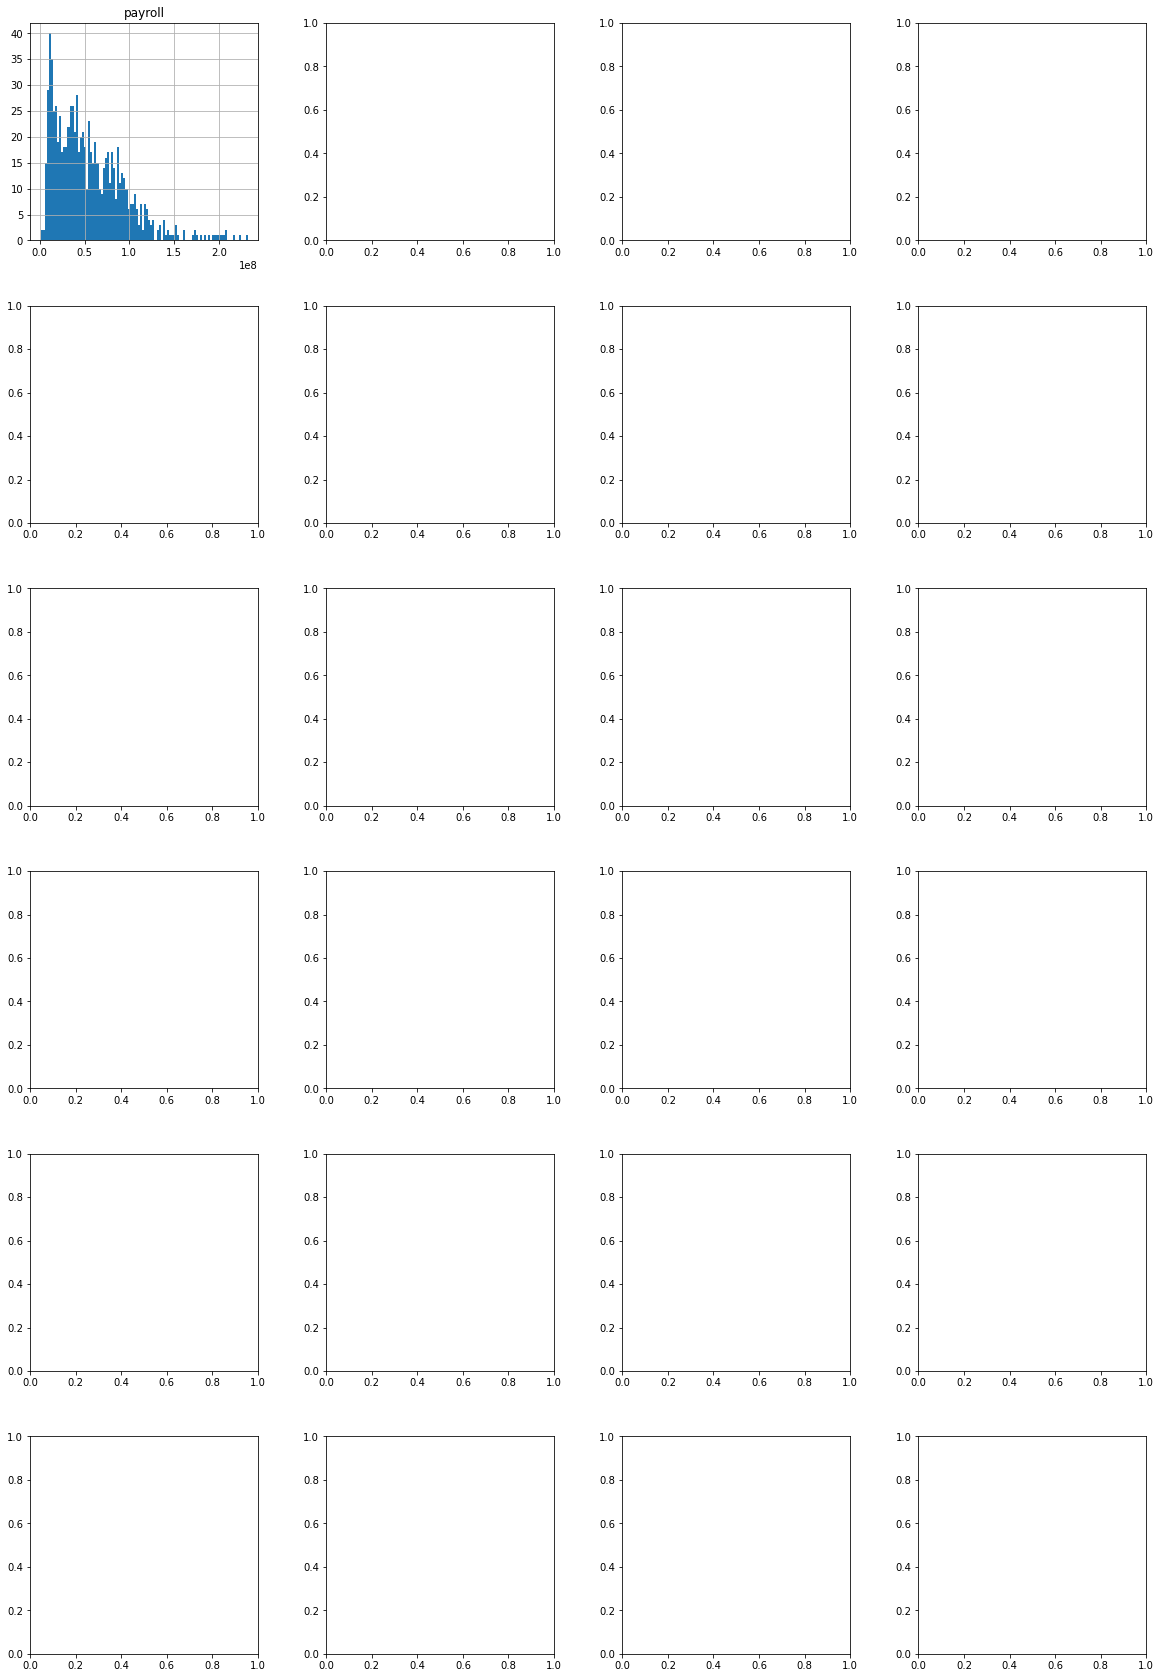

In [7]:
fig, axes = plt.subplots(nrows=6, ncols=4, figsize=(20, 30))
teams.hist(column="payroll", bins=100, ax=axes[0][0])

## Correlation between payroll and winning percentage

### Problem 4

In [8]:
# puts each index from the teams dataframe in a bin based on its year
years = teams.iloc[:, 0].rename("bin")
bins = pd.cut(x=years, bins=[1990, 1995, 2000, 2005, 2010, 2015], labels=["A", "B", "C", "D", "E"], right=False)

# creates new dataframe with a bin column and select columns from the teams dataframe
means = teams.drop(teams.columns.difference(["teamID", "winPercent", "payroll"]), 1).join(bins)

In [9]:
means

,teamID,winPercent,payroll,bin
0,ATL,40.740741,14807000.0,NaN
1,BAL,51.552795,11560712.0,NaN
2,BOS,49.693252,10897560.0,NaN
3,CAL,55.555556,14427894.0,NaN
4,CHA,52.147239,9846178.0,NaN
...,...,...,...,...
853,SLN,55.555556,120693000.0,E
854,TBA,47.530864,72689100.0,E
855,TEX,41.358025,112255059.0,E
856,TOR,51.234568,109920100.0,E


In [10]:
means = means.groupby(by=["bin", "teamID"]).mean()

In [11]:
means

# some bins have NaN because the teams don't exist in that time period, 
# for example the Diamonbacks (ARI) weren't founded until 1998, so they're NaN in bin A (1990-1994)

winPercent      payroll
bin teamID                         
A   ANA            NaN          NaN
    ARI            NaN          NaN
    ATL      56.497726   31721852.8
    BAL      50.444080   23785204.0
    BOS      49.514761   34863216.8
...                ...          ...
E   SLN      55.679012  104445659.0
    TBA      54.992047   60558982.8
    TEX      53.881694   98567688.2
    TOR      48.888889   87203840.0
    WAS      53.024308   90359804.2

[175 rows x 2 columns]

In [12]:
means = means.dropna()

<AxesSubplot:title={'center':'Winning Percentage vs. Payroll (2010-2014)'}, xlabel='payroll', ylabel='winPercent'>

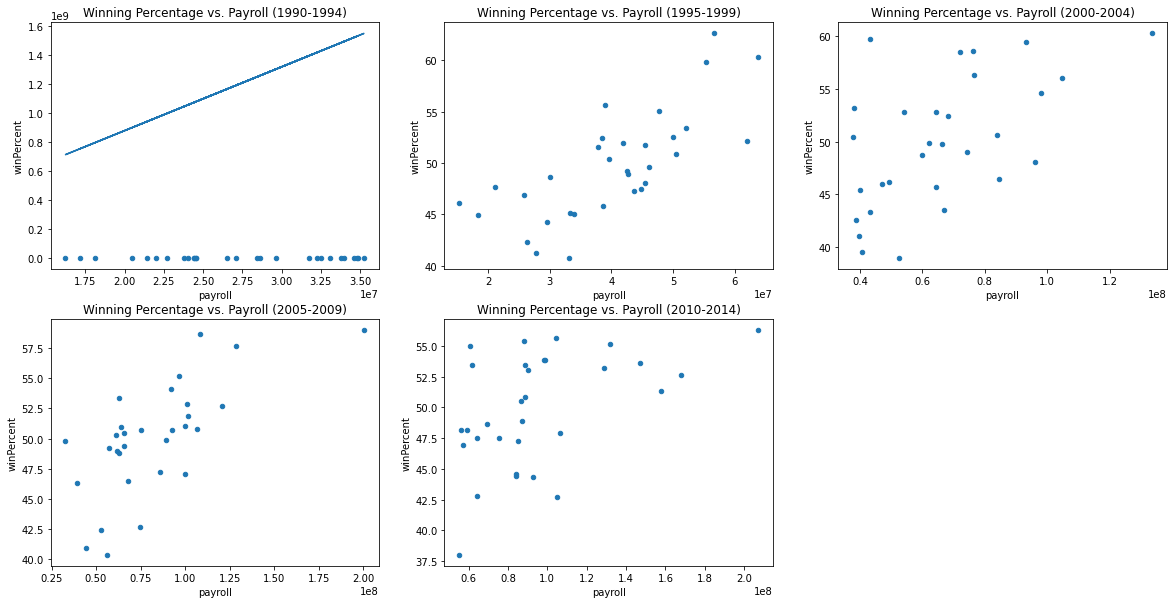

In [57]:
# creates 5 subplots
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(20, 10))
fig.delaxes(axes[1][2])

# plots the data for 1990-1994
means.loc["A"].plot.scatter(x="payroll", y="winPercent", ax=axes[0][0], title="Winning Percentage vs. Payroll (1990-1994)")
# plots best fit line
b, m = np.polyfit(means.loc["A"].reset_index().payroll, means.loc["A"].reset_index().winPercent, 1)
axes[0, 0].plot(means.loc["A"].reset_index().payroll, b + m * means.loc["A"].reset_index().payroll, '-')

# plots the data for 1994-1999
means.loc["B"].plot.scatter(x="payroll", y="winPercent", ax=axes[0][1], title="Winning Percentage vs. Payroll (1995-1999)")

means.loc["C"].plot.scatter(x="payroll", y="winPercent", ax=axes[0][2], title="Winning Percentage vs. Payroll (2000-2004)")
means.loc["D"].plot.scatter(x="payroll", y="winPercent", ax=axes[1][0], title="Winning Percentage vs. Payroll (2005-2009)")
means.loc["E"].plot.scatter(x="payroll", y="winPercent", ax=axes[1][1], title="Winning Percentage vs. Payroll (2010-2014)")

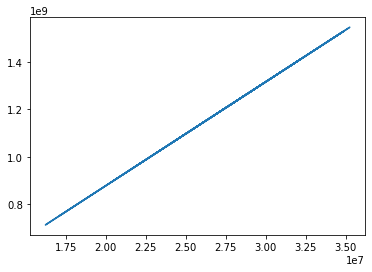

In [56]:
b, m = np.polyfit(means.loc["A"].reset_index().payroll, means.loc["A"].reset_index().winPercent, 1)
#fun = np.poly1d(fit)

plt.plot(means.loc["A"].reset_index().payroll, b + m * means.loc["A"].reset_index().payroll, '-')

In [49]:
means.loc["A"].reset_index().winPercent

0     56.497726
1     50.444080
2     49.514761
3     45.704777
4     56.426308
5     47.740117
6     51.972088
7     46.990058
8     43.328585
9     49.093935
10    41.926999
11    49.256039
12    49.829921
13    50.051982
14    50.121272
15    48.476651
16    54.570642
17    49.673331
18    46.707138
19    52.280702
20    49.144391
21    54.236517
22    45.318139
23    46.527778
24    50.923242
25    49.217391
26    49.987005
27    54.997316
Name: winPercent, dtype: float64

In [54]:
fit

array([2.12728242e-07, 4.38956724e+01])

### Question 2